In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
from scipy.io import loadmat
from torchvision.transforms import ToTensor
import numpy as np

import matplotlib.pyplot as plt

In [4]:
# hypothetical new dataset class with both types of data

ACTION_MAP = {
    'baseball_pitch': 0, 'baseball_swing': 1, 'bench_press': 2, 'bowl': 3,
    'clean_and_jerk': 4, 'golf_swing': 5, 'jump_rope': 6, 'jumping_jacks': 7,
    'pullup': 8, 'pushup': 9, 'situp': 10, 'squat': 11,
    'strum_guitar': 12, 'tennis_forehand': 13, 'tennis_serve': 14
}

# map of all joints
Joint_Map = {"head" : 0,"left_shoulder" : 1,"right_shoulder" : 2,"left_elbow" : 3,
          "right_elbow" : 4,"left_wrist" : 5,"right_wrist" : 6,"left_hip" : 7,"right_hip" : 8,
          "left_knee" : 9,"right_knee" : 10,"left_ankle" : 11,"right_ankle" : 12}

class TestBothDataPennActionDataset(Dataset):
    def __init__(self, frames_dir, labels_dir, transform=None,test=-1):
        self.frames_dir = frames_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.frame_paths = []
        self.action_labels = []
        self.joint_labels = []
        self.datacount = {
    'baseball_pitch': 0, 'baseball_swing': 0, 'bench_press': 0, 'bowl': 0,
    'clean_and_jerk': 0, 'golf_swing': 0, 'jump_rope': 0, 'jumping_jacks': 0,
    'pullup': 0, 'pushup': 0, 'situp': 0, 'squat': 0,
    'strum_guitar': 0, 'tennis_forehand': 0, 'tennis_serve': 0
}
        self.count = 0
        image_sequence_folders = sorted(os.listdir(frames_dir))
        
        for seq_folder in image_sequence_folders:
            if seq_folder != ".DS_Store":
                seq_frames_path = os.path.join(frames_dir, seq_folder)
                frames = sorted(os.listdir(seq_frames_path))
                if frames[0] == ".DS_Store":
                    frames.remove(".DS_Store")

                sampled_frames = frames[::40]
                for frame in sampled_frames:
                    frame_path = os.path.join(seq_frames_path, frame)

                    label_path = os.path.join(labels_dir, seq_folder + '.mat')
                    mat = loadmat(label_path)
                    if(int(mat["train"][0][0]) != test):
                        continue
                    
                    self.frame_paths.append(frame_path)
                    
                    annotation = [[float(mat["x"][0][i]), float(mat["y"][0][i]), float(mat["visibility"][0][i])] for i in
                            range(len(Joint_Map))]
                    action_label = mat['action'][0]

                    # need to work on this
                    self.joint_labels.append(annotation)
                    self.datacount[action_label] += 1
                    self.count += 1
                    
                    self.action_labels.append(ACTION_MAP[action_label])
    
    def __getitem__(self, idx):
        img_path = self.frame_paths[idx]
        img = Image.open(img_path)
        annotation = self.joint_labels[idx]
        if self.transform:
            img = self.transform(img)
        annotation = torch.tensor(annotation)
        label = torch.tensor(self.action_labels[idx])
        return [img,annotation], label

    def __len__(self):
        return len(self.frame_paths)

In [5]:
# joint_training_data = PENNDataset(
#     csv_file  = "../Penn_Action/TrainTable.csv",
#     root_dir="root",
#     transform=ToTensor()
# )
# join_test_data = PENNDataset(
#     csv_file = "../Penn_Action/TrainTable.csv",
#     root_dir="root",
#     transform=ToTensor()
# )

In [6]:
# Convert to Tensor 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalize
])

# Load dataset
frames_dir = "../Step6/Penn_Action/frames"
labels_dir = "../Step6/Penn_Action/labels"

traindataset = TestBothDataPennActionDataset(frames_dir, labels_dir, transform=transform,test=1)
print(traindataset.datacount)
print(traindataset.count)
testdataset = TestBothDataPennActionDataset(frames_dir, labels_dir, transform=transform,test=-1)
print(testdataset.datacount)
print(testdataset.count)
print(traindataset.count + testdataset.count)

{'baseball_pitch': 271, 'baseball_swing': 183, 'bench_press': 182, 'bowl': 263, 'clean_and_jerk': 306, 'golf_swing': 178, 'jump_rope': 63, 'jumping_jacks': 57, 'pullup': 241, 'pushup': 183, 'situp': 130, 'squat': 306, 'strum_guitar': 76, 'tennis_forehand': 143, 'tennis_serve': 238}
2820
{'baseball_pitch': 170, 'baseball_swing': 90, 'bench_press': 178, 'bowl': 176, 'clean_and_jerk': 334, 'golf_swing': 152, 'jump_rope': 71, 'jumping_jacks': 56, 'pullup': 203, 'pushup': 187, 'situp': 135, 'squat': 339, 'strum_guitar': 70, 'tennis_forehand': 124, 'tennis_serve': 142}
2427
5247


In [12]:
class PartiallyConnectedCNN(nn.Module):
    def __init__(self):
        super(PartiallyConnectedCNN, self).__init__()
        self.flatten = nn.Flatten()
        self.image_conv_relu_stack = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            
        )
        self.image_linear_stack = nn.Sequential(
            nn.Linear(401408 , 128),
            nn.Sigmoid(),
            nn.Linear(128, 32),
            nn.Sigmoid(),
            nn.Linear(32, 15),
            nn.LogSoftmax(dim=0)
        )
        self.joint_conv_relu_stack = nn.Sequential(
                                               nn.Conv1d(in_channels=13, out_channels=39, kernel_size = 1),
                                               nn.ReLU(),
                                               
                                                nn.Conv1d(in_channels=39, out_channels=39, kernel_size = 1),
                                               nn.ReLU(),
                                               nn.Conv1d(in_channels=39, out_channels=39, kernel_size = 1),
                                               nn.ReLU()
        )
        self.joint_linear = nn.Sequential(nn.Linear(117,512),
                                        nn.Sigmoid(),
                                        nn.Linear(512,15),
                                        nn.LogSoftmax(dim=0))
        self.combined_linear = nn.Sequential(
            nn.Linear(30,15),
        )


    def forward(self, input):
        x = input[0]
        y = input[1]
        
        x = self.image_conv_relu_stack(x)
        x = self.flatten(x)
        x = self.image_linear_stack(x)
        y = self.joint_conv_relu_stack(y)
        y = self.flatten(y)
        y = self.joint_linear(y)
        final = torch.cat((x,y),dim=1)
        self.combined_linear(final);

        
        return final

In [13]:

# Data loaders
train_loader = DataLoader(traindataset, batch_size=32, shuffle=True)
test_loader = DataLoader(testdataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = PartiallyConnectedCNN().to(device)

Using device: cpu


In [14]:
# Cross-entropy loss as the loss function
loss_fn = nn.CrossEntropyLoss()

#optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
train_losses = []
test_accuracies = []

In [ ]:
testing = True
epochs = 15
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    model.train()
        

        # training 
    for inputs, labels in train_loader:
        #inputs, labels = inputs.to(device), labels.to(device)

        # backpropagation 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()  # weight update 
    
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # testing 
    # Set model to eval mode 
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            #inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    test_accuracies.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs},TrainLoss: {running_loss/len(train_loader):.4f}, "
            f"TTrainAccuracy: {100 * correct/total:.2f}% TestLoss: {val_loss/len(test_loader):.4f}, "
            f"TestAccuracy: {100 * val_correct/val_total:.2f}% ")


Epoch 1/30,TrainLoss: 2.9190, TTrainAccuracy: 21.06% TestLoss: 3.1576, TestAccuracy: 9.48% 
Epoch 2/30,TrainLoss: 2.4051, TTrainAccuracy: 37.13% TestLoss: 3.2216, TestAccuracy: 10.26% 
Epoch 3/30,TrainLoss: 1.9334, TTrainAccuracy: 56.10% TestLoss: 3.3161, TestAccuracy: 12.15% 
Epoch 4/30,TrainLoss: 1.5296, TTrainAccuracy: 70.07% TestLoss: 3.3989, TestAccuracy: 11.91% 
Epoch 5/30,TrainLoss: 1.2291, TTrainAccuracy: 77.59% TestLoss: 3.5743, TestAccuracy: 12.11% 
Epoch 6/30,TrainLoss: 0.9975, TTrainAccuracy: 81.35% TestLoss: 3.6848, TestAccuracy: 11.91% 


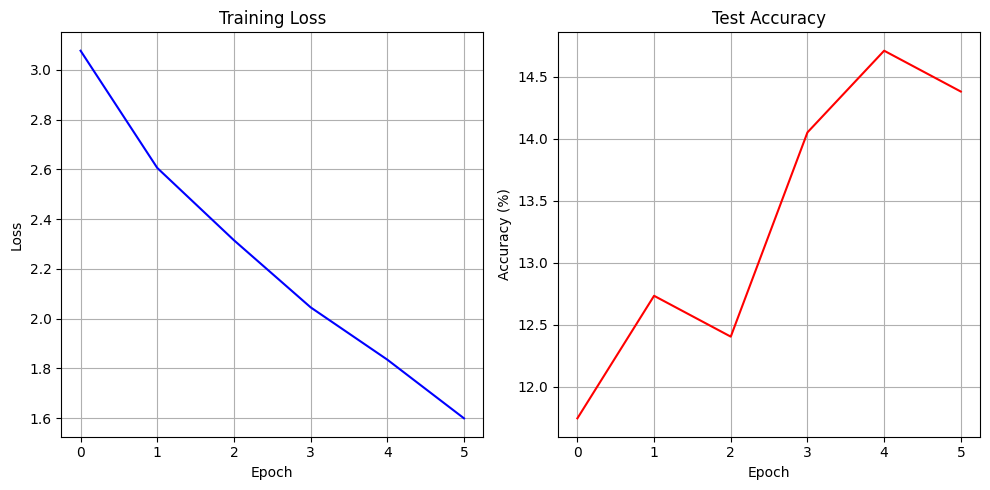

In [31]:
# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(len(test_accuracies)), test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()